# Numbers Summation (using RNN LSTM)

> - <font size="+1">🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**</font><br/><br/>
> - ▶️ <font size="+1">**Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments)</font>

## Experiment overview

In this experiment we will use [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) to sum up two numbers (each number is in a range of `[1, 99]`). The summation expression (i.e. `"1+45"` or `37+68`) that will be sent to the RNN _input_ will be treated as a **string** (sequence of characters) and the _output_ of the RNN will also be a string (i.e. `"46"` or `"106"`) - the sequence of characters that will represent the result of summation. This is a "sequence-to-sequence" version of RNN implementation. We will use LSTM ([Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory)) recurent neural network for this task.

For this experiment we will use [Tensorflow v2](https://www.tensorflow.org/) with its [Keras API](https://www.tensorflow.org/guide/keras).

![numbers_summation_rnn.png](../../demos/src/images/numbers_summation_rnn.png)

Inspired by [Learn to Add Numbers with an Encoder-Decoder LSTM Recurrent Neural Network](https://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/) article.

## Import dependencies

In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Generate a dataset

In order to train a neural network we need to generate a training dataset which will consist of examples `x` (set of summation expressions) and labels `y` (set of correct answers for each expression). We will start with generating a set of _numbers_ (not strings so far) and than we will convert the sets of numbers into _strings_.

In [4]:
dataset_size = 5000
sequence_length = 2
max_num = 100

In [5]:
# Generates summation sequences and summation results in form of vector if numbers.
def generate_sums(dataset_size, sequence_length, max_num):
    # Initial dataset states.
    x, y = [], []
    
    # Generating sums.
    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [6]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:3])
print()
print('y_train:\n', y_train[:3])

x_train:
 [[13, 8], [85, 91], [12, 22]]

y_train:
 [21, 176, 34]


Recurrent neural networks are normally deals with the sequences (of one or many elements) on the input. In order to treat a summation expression as a sequence we will convert array of numbers (i.e. `[[13, 8], [85, 91], ...]`) into strings (i.e. `['13+8   ', '85+91  ', ...]`). We also want to add a space `" "` paddings to each string to make them all of the same length. After doing that we will be able to feed our RNN character by character (i.e. `1`, then `3`, then `+`, then `8`, then ` ` and so on).

In [7]:
# Convert array of numbers for x and y into strings.
# Also it adds a space (" ") padding to strings to make them of the same length. 
def dataset_to_strings(x, y, max_num):
    # Initial dataset states.
    x_str, y_str = [], []
    
    sequnce_length = len(x[0])
    
    # Calculate the maximum length of equation (x) string (i.e. of "11+99")
    num_of_pluses = sequnce_length - 1
    num_of_chars_per_digit = math.ceil(math.log10(max_num + 1))
    max_x_length = sequnce_length * num_of_chars_per_digit + num_of_pluses
    
    # Calculate the maximum length of label (y) string (i.e. of "167")
    max_y_length = math.ceil(math.log10(sequnce_length * (max_num + 1)))
    
    # Add a space " " padding to equation strings to make them of the same length.
    for example in x:
        str_example = '+'.join([str(digit) for digit in example])
        str_example += ''.join([' ' for padding in range(max_x_length - len(str_example))])
        x_str.append(str_example)
    
    # Add a space " " padding to labels strings to make them of the same length.
    for label in y:
        str_example = str(label)
        str_example += ''.join([' ' for padding in range(max_y_length - len(str_example))])
        y_str.append(str_example)
    
    return x_str, y_str

In [8]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['13+8   ' '85+91  ' '12+22  ']

y_train_str:
 ['21 ' '176' '34 ']


In [9]:
# Since we allow only numbers, plus sign and spaces the vocabulary looks pretty simple.
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [10]:
# Python dictionary that will convert a character to its index in the vocabulary.
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


Our RNN need to have a digits as an input to operate with (and not a strings). To convert summation expressions strings into number the first step we will do is to convert each character of each string into the position index of this character in the `vocabulary`.

In [11]:
# Converts x and y arrays of strings into array of char indices.
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [12]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[ 1  3 10  8 11 11 11]
 [ 8  5 10  9  1 11 11]
 [ 1  2 10  2  2 11 11]]

y_train_encoded:
 [[ 2  1 11]
 [ 1  7  6]
 [ 3  4 11]]


To make our dataset even more understandable for our recurrent neural network we will convert each number into `0/1` [one-hot vector](https://en.wikipedia.org/wiki/One-hot) (i.e. number `1` will be transformed into array `[0 1 0 0 0 0 0 0 0 0 0 0]`).

In [13]:
# Convert x and y sets of numbers into one-hot vectors.
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [14]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_train_one_hot:
 [[[0 0 1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


Now we may combine all the function together and create a one function that will do all the work to generate a dataset in the proper format for us.

In [15]:
# Generates a dataset.
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    # Generate integet sum sequences.
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    # Convert integer sum sequences into strings.
    x, y = dataset_to_strings(x, y, max_num)
    # Encode each character to a char indices.
    x, y = dataset_to_indices(x, y, vocabulary)
    # Encode each index into one-hot vector.
    x, y = dataset_to_one_hot(x, y, vocabulary)
    # Return the data.
    return np.array(x), np.array(y)

In [16]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y:
 [[[0 0 0 0 0 0 1 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


In [17]:
print('x.shape: ', x.shape) # (input_sequences_num, input_sequence_length, supported_symbols_num)
print('y.shape: ', y.shape) # (output_sequences_num, output_sequence_length, supported_symbols_num)

x.shape:  (5000, 7, 12)
y.shape:  (5000, 3, 12)


In [19]:
# How many characters each summation expression has.
input_sequence_length = x.shape[1]

# How many characters the output sequence of the RNN has.
output_sequence_length = y.shape[1]

# The length of one-hot vector for each character in the input (should be the same as vocabulary_size).
supported_symbols_num = x.shape[2]

# The number of different characters our RNN network could work with (i.e. it understands only digits, "+" and " ").
vocabulary_size = len(vocabulary)

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)
print('vocabulary_size: ', vocabulary_size)

input_sequence_length:  7
output_sequence_length:  3
supported_symbols_num:  12
vocabulary_size:  12


In [21]:
# Converts a sequence (array) of one-hot encoded vectors back into the string based on the provided vocabulary.
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [23]:
decode(y[0], vocabulary)

'61 '

## Build a model

We will use a [Sequential] TensorFlow model with [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers. Logically our model will consist of **encoder** and **decoder**. _Encoder_ will encode the input expression into an array of numbers. And then _decoder_ will try to build an output result sequence by decoding the array of numbers from encoder.

In [24]:
epochs_num = 150
batch_size = 128

In [25]:
model = tf.keras.models.Sequential()

# Encoder
# -------

model.add(tf.keras.layers.LSTM(
    units=128,
    input_shape=(input_sequence_length, vocabulary_size),
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

# Decoder
# -------

# We need this layer to match the encoder output shape with decoder input shape.
# Encoder outputs ONE vector of numbers but for decoder we need have output_sequence_length vectors.
model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=128,
    return_sequences=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=vocabulary_size,
    )
))

model.add(tf.keras.layers.Activation(
    activation='softmax'
))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 12)             1548      
_________________________________________________________________
activation (Activation)      (None, 3, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


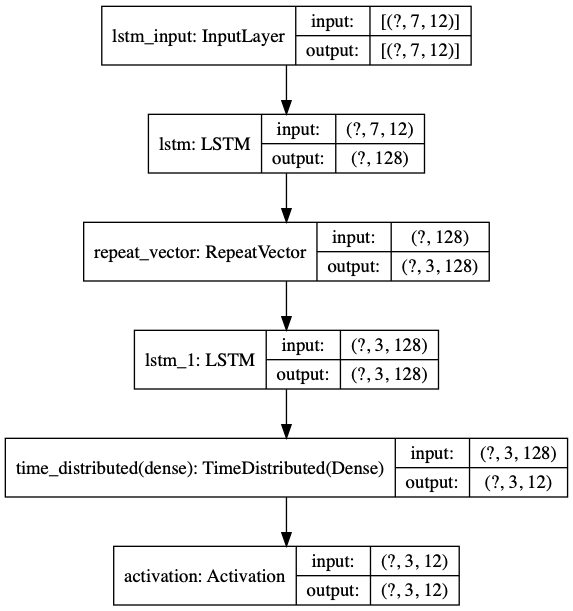

In [27]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Train a model

In [28]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.1
)

Train on 4500 samples, validate on 500 samples
Epoch 1/150
4500/4500 [==============================] - 5s 1ms/sample - loss: 2.2913 - accuracy: 0.2495 - val_loss: 2.0760 - val_accuracy: 0.3720
Epoch 2/150
4500/4500 [==============================] - 1s 253us/sample - loss: 1.9432 - accuracy: 0.3792 - val_loss: 1.8413 - val_accuracy: 0.3693
Epoch 3/150
4500/4500 [==============================] - 1s 253us/sample - loss: 1.8112 - accuracy: 0.3835 - val_loss: 1.7404 - val_accuracy: 0.4040
Epoch 4/150
4500/4500 [==============================] - 1s 276us/sample - loss: 1.7523 - accuracy: 0.3907 - val_loss: 1.7100 - val_accuracy: 0.4053
Epoch 5/150
4500/4500 [==============================] - 1s 251us/sample - loss: 1.7058 - accuracy: 0.4056 - val_loss: 1.6672 - val_accuracy: 0.4020
Epoch 6/150
4500/4500 [==============================] - 1s 268us/sample - loss: 1.6796 - accuracy: 0.4056 - val_loss: 1.7511 - val_accuracy: 0.3800
Epoch 7/150
4500/4500 [==============================] - 1s 2

4500/4500 [==============================] - 1s 242us/sample - loss: 0.6624 - accuracy: 0.7738 - val_loss: 0.7833 - val_accuracy: 0.7060
Epoch 56/150
4500/4500 [==============================] - 1s 236us/sample - loss: 0.6364 - accuracy: 0.7848 - val_loss: 0.6236 - val_accuracy: 0.7880
Epoch 57/150
4500/4500 [==============================] - 1s 241us/sample - loss: 0.5892 - accuracy: 0.8060 - val_loss: 0.6265 - val_accuracy: 0.7787
Epoch 58/150
4500/4500 [==============================] - 2s 340us/sample - loss: 0.5628 - accuracy: 0.8169 - val_loss: 0.5671 - val_accuracy: 0.8167
Epoch 59/150
4500/4500 [==============================] - 1s 333us/sample - loss: 0.5579 - accuracy: 0.8153 - val_loss: 0.5993 - val_accuracy: 0.7867
Epoch 60/150
4500/4500 [==============================] - 1s 296us/sample - loss: 0.5135 - accuracy: 0.8376 - val_loss: 0.5326 - val_accuracy: 0.8167
Epoch 61/150
4500/4500 [==============================] - 1s 288us/sample - loss: 0.4701 - accuracy: 0.8630 - val

4500/4500 [==============================] - 2s 335us/sample - loss: 0.0401 - accuracy: 0.9962 - val_loss: 0.0585 - val_accuracy: 0.9880
Epoch 110/150
4500/4500 [==============================] - 1s 284us/sample - loss: 0.3867 - accuracy: 0.8790 - val_loss: 0.5718 - val_accuracy: 0.7873
Epoch 111/150
4500/4500 [==============================] - 1s 301us/sample - loss: 0.2207 - accuracy: 0.9295 - val_loss: 0.1009 - val_accuracy: 0.9840
Epoch 112/150
4500/4500 [==============================] - 1s 258us/sample - loss: 0.0623 - accuracy: 0.9930 - val_loss: 0.0654 - val_accuracy: 0.9887
Epoch 113/150
4500/4500 [==============================] - 2s 368us/sample - loss: 0.0465 - accuracy: 0.9958 - val_loss: 0.0554 - val_accuracy: 0.9927
Epoch 114/150
4500/4500 [==============================] - 2s 343us/sample - loss: 0.0397 - accuracy: 0.9971 - val_loss: 0.0507 - val_accuracy: 0.9933
Epoch 115/150
4500/4500 [==============================] - 1s 308us/sample - loss: 0.0361 - accuracy: 0.9986

In [30]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

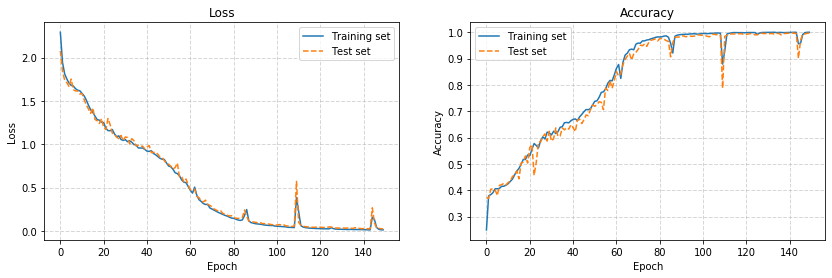

In [31]:
render_training_history(history)

## Test a dataset

In [32]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_test:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]]]


In [33]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

predictions.shape:  (5000, 3, 12)

predictions[0]:
 [[2.94124967e-11 9.99999881e-01 5.40416279e-12 6.99695735e-17
  2.65061544e-16 7.96917142e-15 3.80527814e-12 2.37020854e-11
  6.39340580e-10 6.19693239e-08 1.88765341e-14 3.12135426e-16]
 [7.47985212e-07 5.28313970e-09 2.15915315e-06 1.06114959e-02
  9.89104927e-01 2.79036001e-04 1.52820087e-06 8.55734754e-08
  1.61145564e-07 1.25433939e-08 2.21222429e-10 7.25569995e-12]
 [9.95484710e-01 3.78623931e-03 1.78292635e-06 3.17329690e-10
  7.71321115e-12 1.10704404e-10 1.85979270e-11 7.16798676e-10
  1.58211421e-07 7.27166596e-04 8.12576222e-12 1.01984705e-10]]

predictions[1]:
 [[1.61490168e-10 9.99998689e-01 7.90365863e-12 3.88086376e-17
  1.81524355e-17 1.37621699e-15 7.35062618e-12 1.33187017e-10
  3.91239174e-09 1.33034212e-06 1.25870892e-14 8.31044936e-16]
 [4.22439800e-04 3.78208794e-03 9.92229640e-01 3.52799450e-03
  4.18706622e-06 2.79278325e-08 9.21405388e-08 3.93229129e-07
  7.69591406e-06 2.54043807e-05 1.93961669e-09 5.39844280

In [34]:
x_encoded = [decode(example, vocabulary) for example in x_test]
y_expected = [decode(label, vocabulary) for label in y_test]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 40
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

44+96   = 140 [predict: 140] ✓
88+41   = 129 [predict: 129] ✓
65+68   = 133 [predict: 133] ✓
10+42   = 52  [predict: 52 ] ✓
42+97   = 139 [predict: 139] ✓
70+58   = 128 [predict: 128] ✓
86+53   = 139 [predict: 139] ✓
33+41   = 74  [predict: 74 ] ✓
30+30   = 60  [predict: 60 ] ✓
5+5     = 10  [predict: 10 ] ✓
86+75   = 161 [predict: 161] ✓
81+49   = 130 [predict: 130] ✓
71+71   = 142 [predict: 142] ✓
81+86   = 167 [predict: 167] ✓
46+100  = 146 [predict: 756] 
53+41   = 94  [predict: 94 ] ✓
94+31   = 125 [predict: 125] ✓
13+34   = 47  [predict: 47 ] ✓
9+74    = 83  [predict: 83 ] ✓
94+91   = 185 [predict: 185] ✓
94+52   = 146 [predict: 146] ✓
35+58   = 93  [predict: 93 ] ✓
20+10   = 30  [predict: 30 ] ✓
67+32   = 99  [predict: 99 ] ✓
88+80   = 168 [predict: 168] ✓
19+92   = 111 [predict: 111] ✓
76+51   = 127 [predict: 127] ✓
27+20   = 47  [predict: 47 ] ✓
66+6    = 72  [predict: 72 ] ✓
36+69   = 105 [predict: 105] ✓
72+84   = 156 [predict: 156] ✓
68+84   = 152 [predict: 152] ✓
72+13   =

## Save a model

In [35]:
model_name = 'numbers_summation_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/numbers_summation_rnn/numbers_summation_rnn.h5 \
  ./demos/public/models/numbers_summation_rnn
```

You may find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.